***AVISO**: Esse Notebook foi feito com base na estrutura do Databricks Free Edition, que utiliza catálogos.*

# **ETAPA 5 - ANÁLISES AD-HOC**

---
---

<br>

Essa etapa será responsável por responder perguntas pré-selecionadas que são ad-hoc's, utilizando resultado gerado pela estrutura completa das etapas anteriores.

*`Complete as informações necessárias nos trechos que estão destacados em vermelho assim como esse, seguindo o padrão snake_case.`*

<br><br>

---
---

### Pergunta de Negócio 01 - **_Como evoluíram as vendas mensais por categoria entre 2022 e 2025?_**

> **CONSULTA:** Agregação mensal (ano/mes) de valor_total por categoria_id/categoria_nome.

> **INSIGHT ESPERADO:** Identificar sazonalidade e categorias com maior crescimento relativo.

A seguir, código que executa consulta com cenário da pergunta:

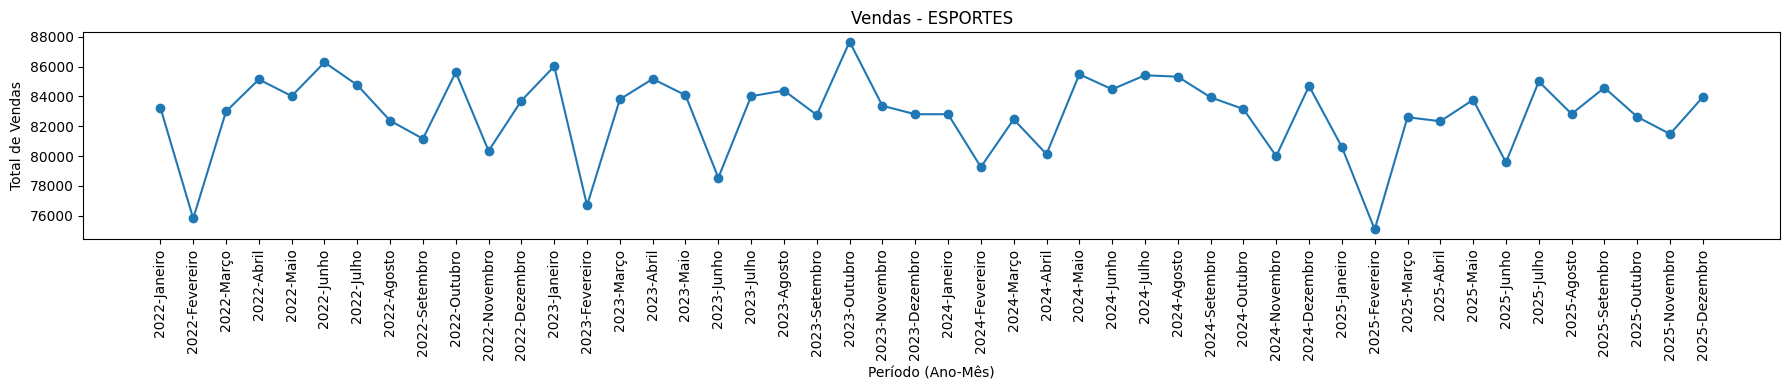

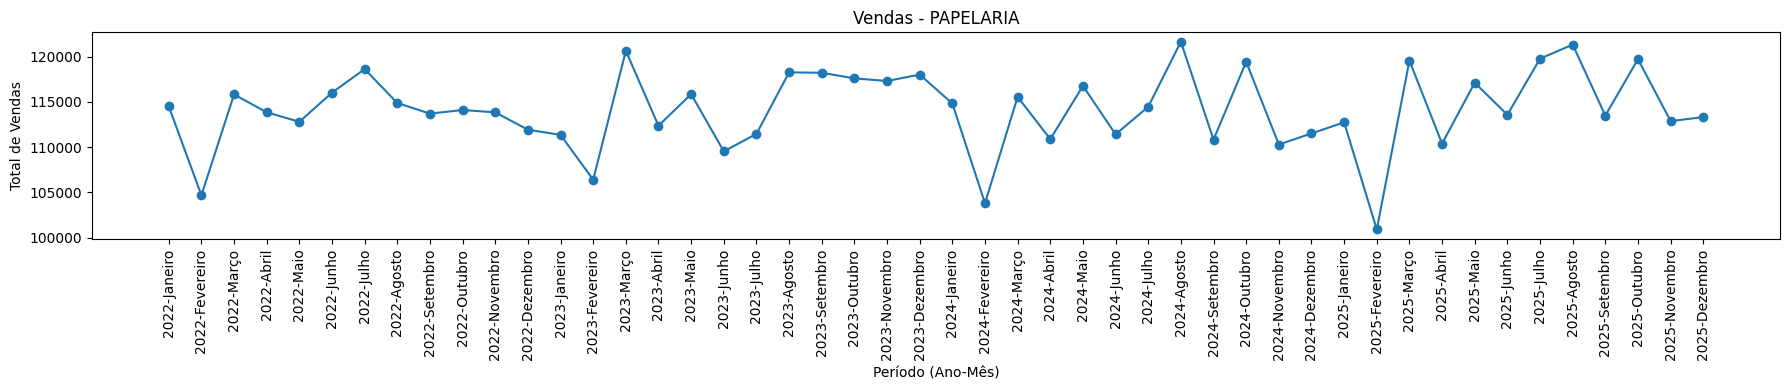

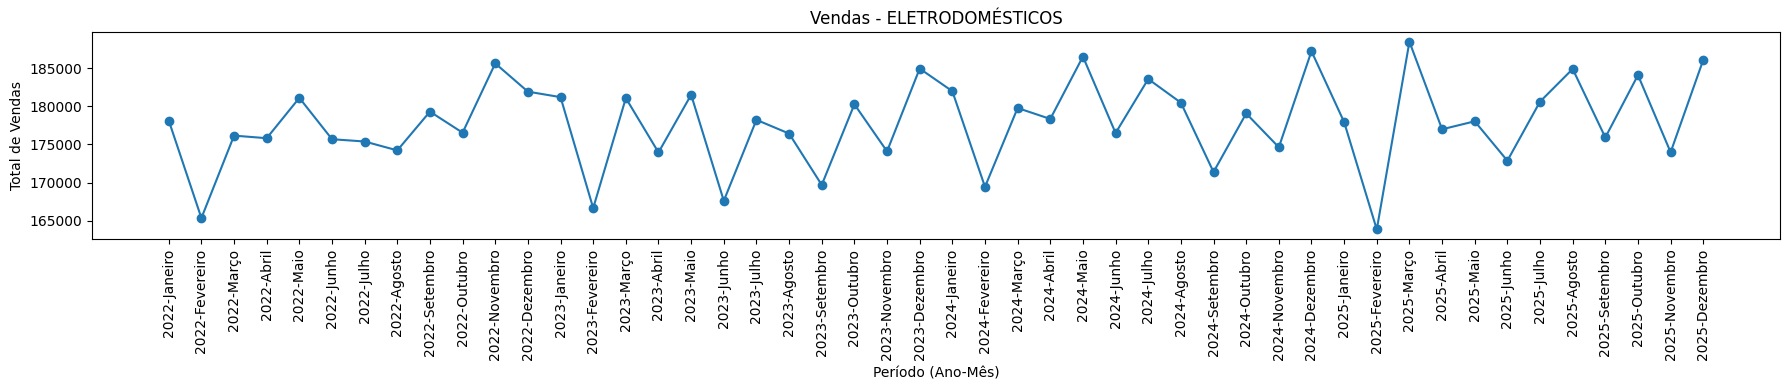

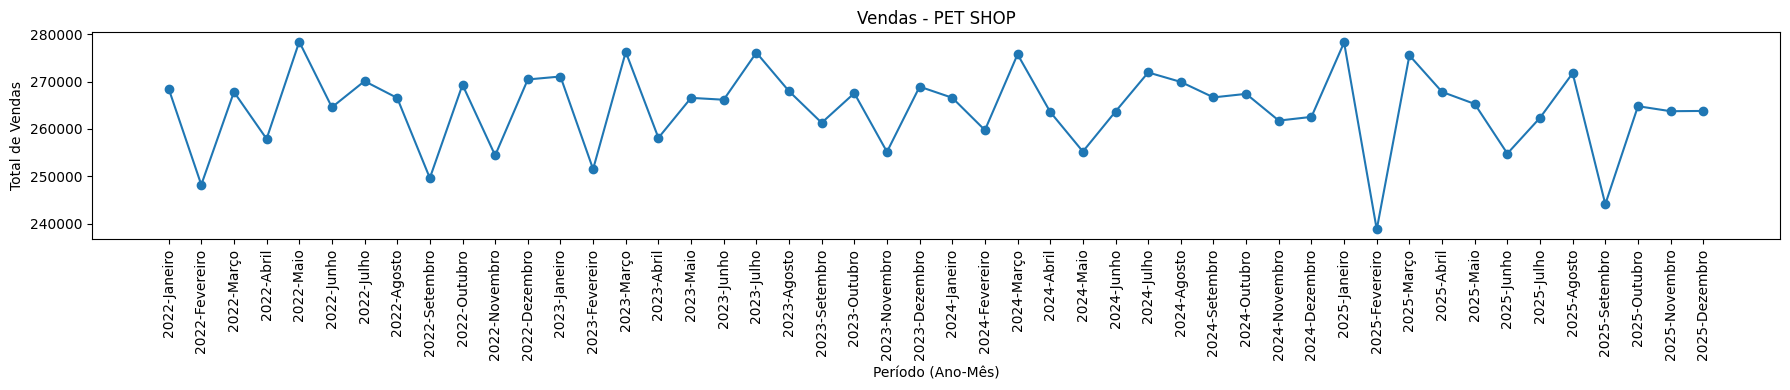

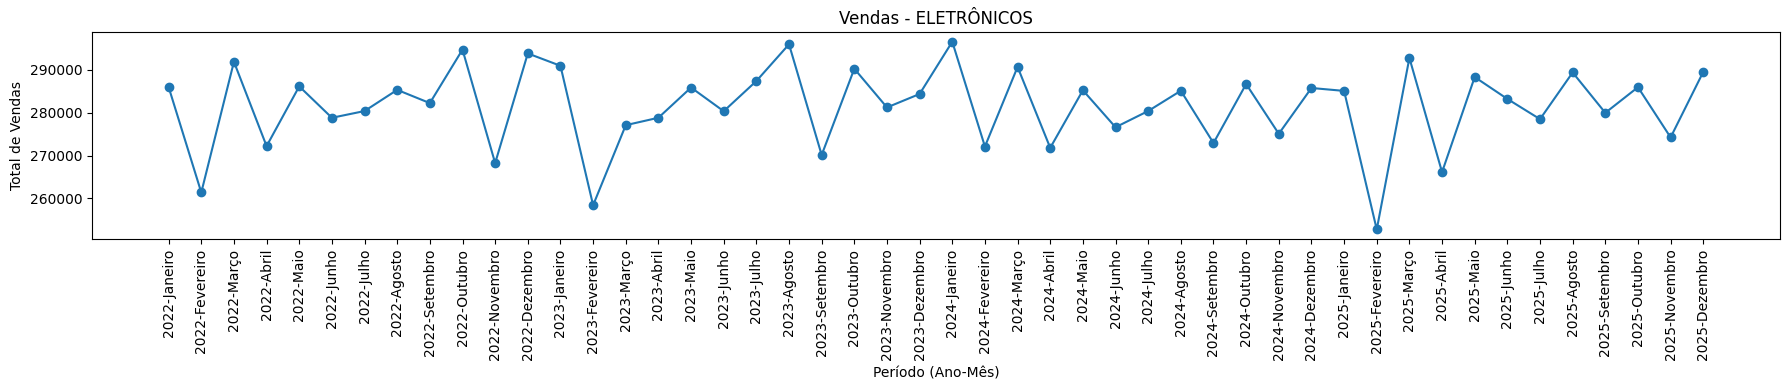

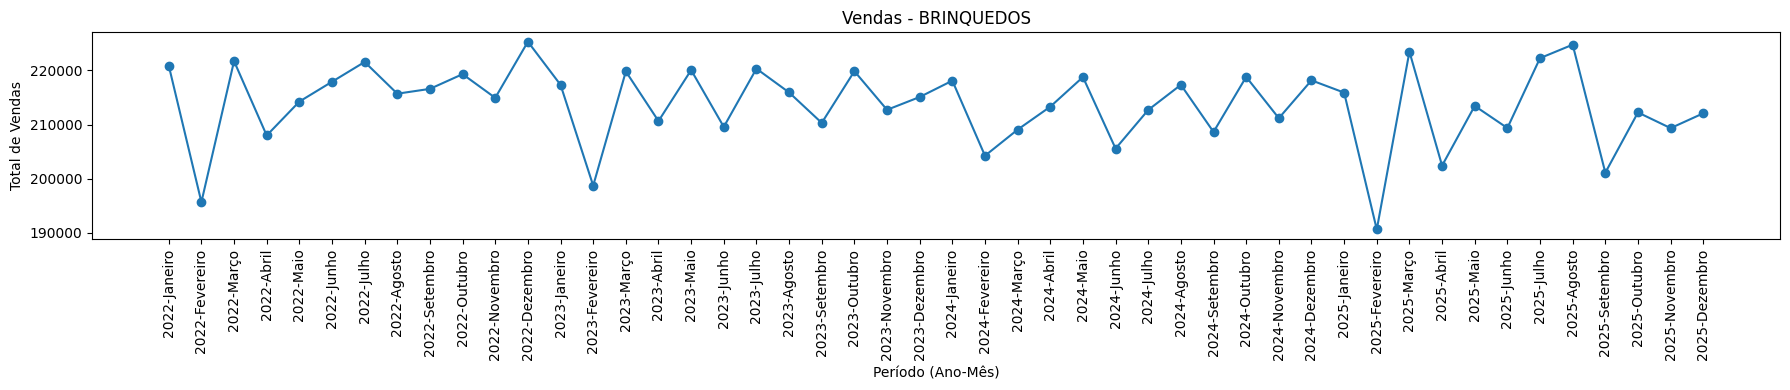

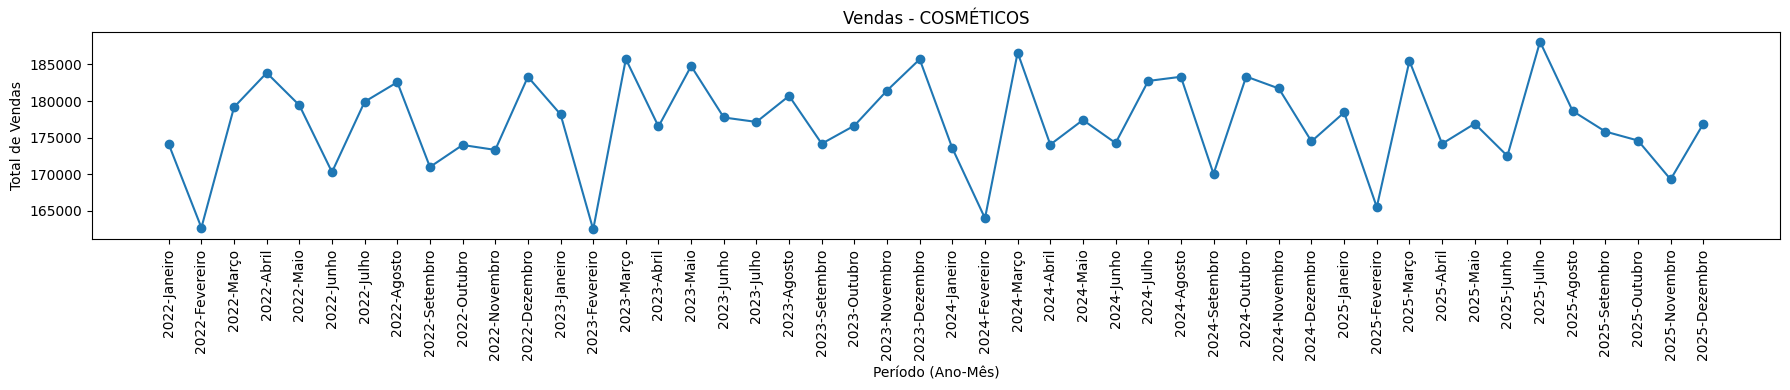

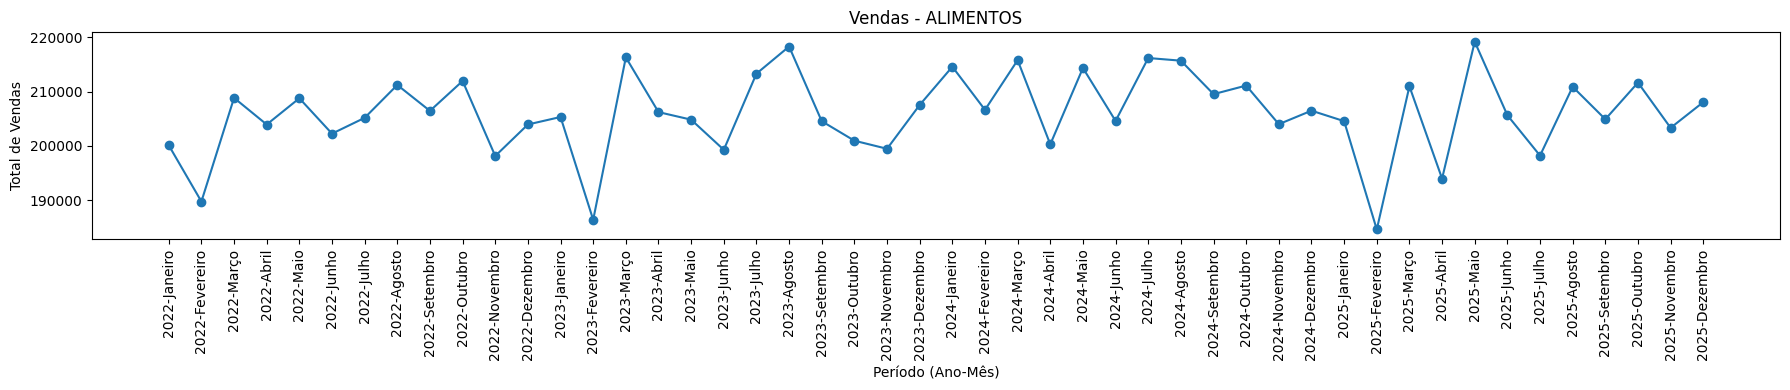

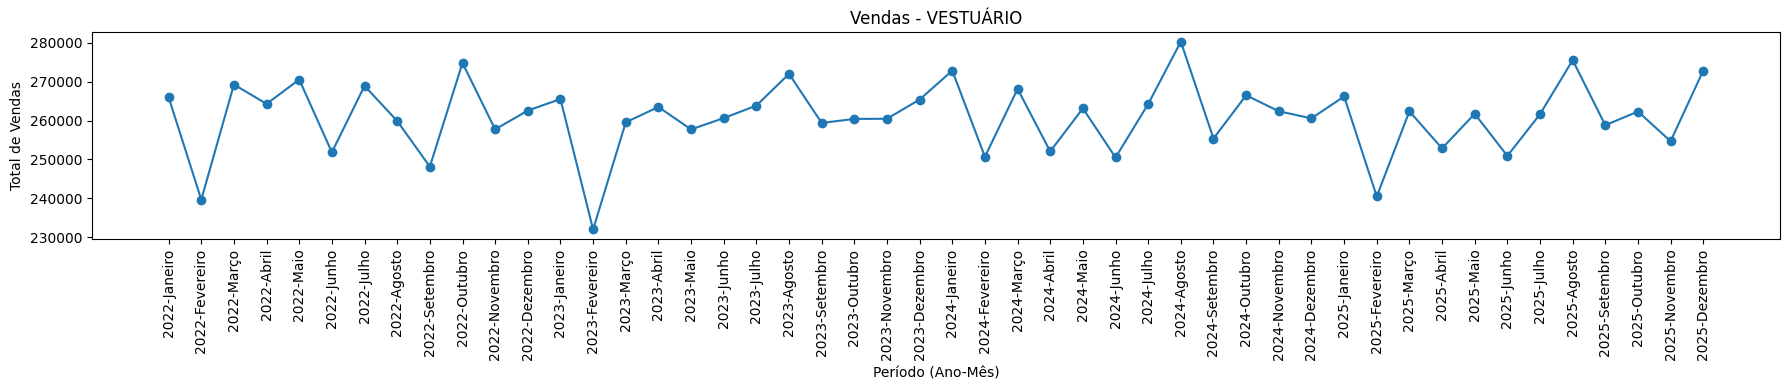

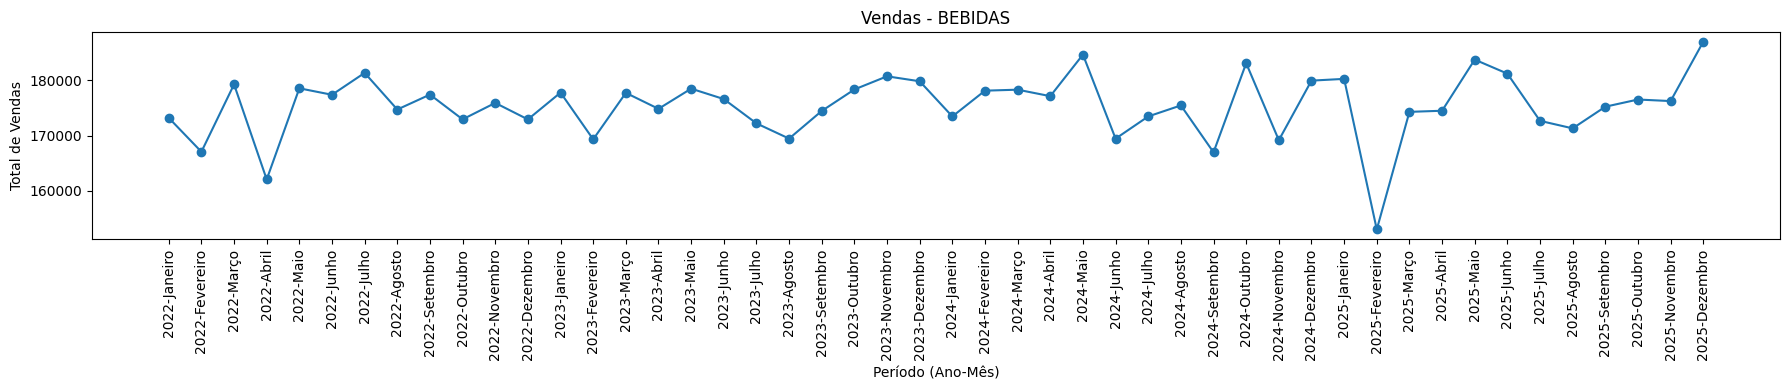

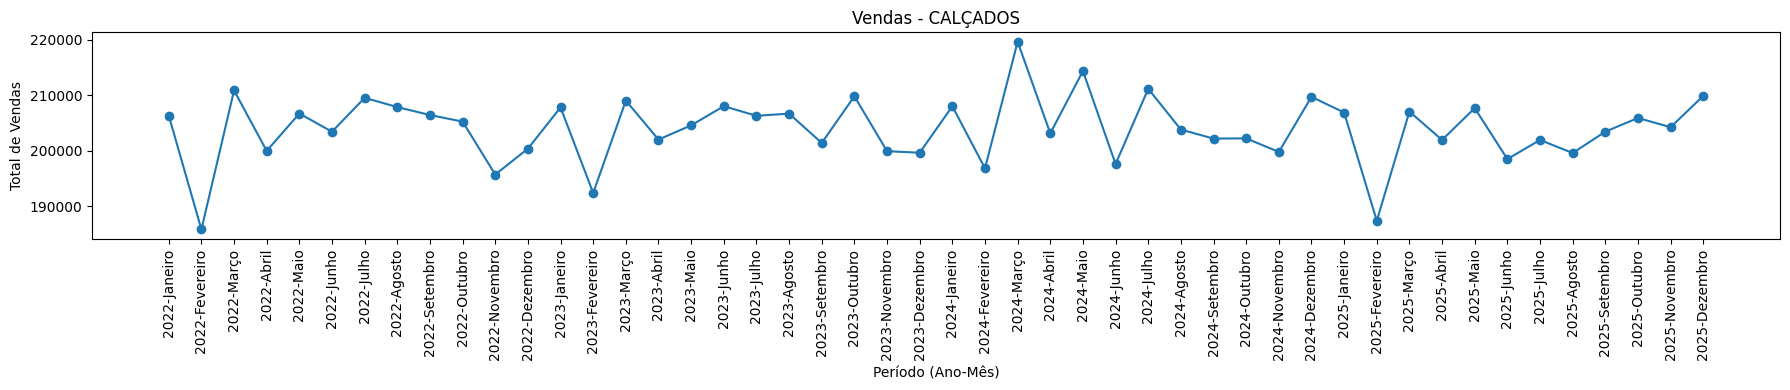

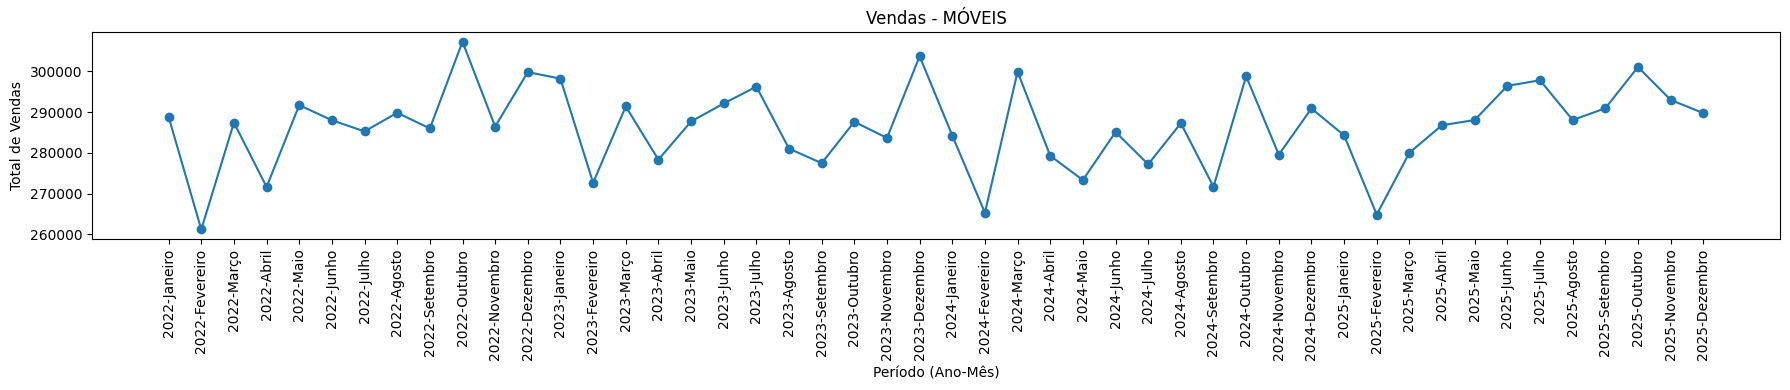

In [0]:
from pyspark.sql.functions import sum, col, desc, row_number, round
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.functions import lit

# Tabela fato_vendas 
fato_vendas = "dataexperts.gold.fato_vendas"
dim_categoria  = "dataexperts.gold.dim_categoria_produto"

# Seleção da categoria e de sua respectiva sk
categoria_produto = (
    spark.table(dim_categoria)
         .select("categoria_nome", "sk_categoria")
         .distinct()
)

# Seleção de vendas totais por categoria em função de ano/mes
vendas = (spark.table(fato_vendas)
                    .groupBy("ano", "mes", "sk_categoria")
                    .agg(sum("valor_total").alias("total_vendas"))  
                )

vendas = (vendas.join(categoria_produto.select("sk_categoria", "categoria_nome"), on="sk_categoria").drop("sk_categoria"))

# Separacao por categoria
for categoria in categoria_produto.select("categoria_nome").collect():
    vendas = vendas.withColumn(
        "mes_num",
        when(col("mes") == "Janeiro", lit(1))
        .when(col("mes") == "Fevereiro", lit(2))
        .when(col("mes") == "Março", lit(3))
        .when(col("mes") == "Abril", lit(4))
        .when(col("mes") == "Maio", lit(5))
        .when(col("mes") == "Junho", lit(6))
        .when(col("mes") == "Julho", lit(7))
        .when(col("mes") == "Agosto", lit(8))
        .when(col("mes") == "Setembro", lit(9))
        .when(col("mes") == "Outubro", lit(10))
        .when(col("mes") == "Novembro", lit(11))
        .otherwise(lit(12))
    )

    vendas_categoria = (
        vendas
            .filter(col("categoria_nome") == categoria.categoria_nome)
            .orderBy("ano", "mes_num")
            .select("ano", "mes", "total_vendas")
            .collect()
    )
    
    if not vendas_categoria:
        continue

    x = [f"{r.ano}-{str(r.mes).zfill(2)}" for r in vendas_categoria]
    y = [r.total_vendas for r in vendas_categoria]

    # Plot
    plt.figure(figsize=(18, 4))
    plt.plot(x, y, marker="o")
    plt.title(f"Vendas - {categoria.categoria_nome}")
    plt.xlabel("Período (Ano-Mês)")
    plt.ylabel("Total de Vendas")
    plt.xticks(rotation=90)
    plt.tight_layout()

**CONCLUSÃO FINAL:** <br>
_A análise da evolução das vendas mensais por categoria entre 2022 e 2025 mostra um comportamento relativamente estável ao longo do tempo, com oscilações pontuais que sugerem sazonalidade moderada, especialmente quedas recorrentes no início do ano (principalmente em janeiro) e picos em meses intermediários ou próximos ao segundo semestre. Categorias como MÓVEIS, ELETRÔNICOS, VESTUÁRIO e PET SHOP apresentam os maiores volumes absolutos e maior volatilidade, indicando maior sensibilidade a ciclos econômicos e períodos promocionais, enquanto PAPELARIA, ESPORTES e BEBIDAS mantêm variações mais suaves e previsíveis. No geral, não há rupturas bruscas de tendência, o que sugere crescimento consistente e maturidade do portfólio, com oportunidades claras para ações sazonais direcionadas às categorias de maior ticket e maior amplitude de variação._

### Pergunta de negócio 02 - **_Quais os top 10 produtos por valor_total e sua participação no total?_**  

> **CONSULTA:** Ranking por valor_total com cálculo de participação (%) sobre o total geral.

> **INSIGHT ESPERADO:** Concentração de receita e dependência de poucos produtos.

In [0]:
from pyspark.sql.functions import sum, col, desc, row_number, round
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

fato_vendas = "dataexperts.gold.fato_vendas"
dim_categoria = "dataexperts.gold.dim_categoria_produto"
dim_produto = "dataexperts.gold.dim_produto"

# Tabelas
produtos = spark.table(dim_produto).select("sk_produto", "produto_id")
categorias = spark.table(dim_categoria).select("sk_categoria", "categoria_nome")

vendas_categoria = spark.table(fato_vendas).groupBy("sk_categoria").agg(sum("valor_total").alias("vendas_categoria"))
vendas_produtos = spark.table(fato_vendas).groupBy("sk_produto", "sk_categoria").agg(sum("valor_total").alias("vendas_produto"))

vendas_totais = vendas_categoria.agg(sum("vendas_categoria")).first()[0]

# Join para saber o id dos produtos e o nome das categorias
vendas_categoria = vendas_categoria.join(categorias.select("sk_categoria", "categoria_nome"), on="sk_categoria").drop("sk_categoria")

vendas_produtos = vendas_produtos.join(categorias.select("sk_categoria", "categoria_nome"), on="sk_categoria").drop("sk_categoria")
vendas_produtos = vendas_produtos.join(produtos.select("sk_produto", "produto_id"), on="sk_produto").drop("sk_produto")


# VENDAS POR PRODUTO (2022~2025)
produtos_rank = vendas_produtos.withColumn("rank", row_number().over(Window.orderBy(col("vendas_produto").desc())))

top_10 = produtos_rank.filter(col("rank") <= 10)
x = top_10.withColumn("participacao [%]", round((col("vendas_produto") * 100) / vendas_totais, 4) )

print("VENDAS POR PRODUTOS")
print("Número de categorias: ", categorias.count())
print("Número de produtos: ", produtos.count())

y = x.agg(sum("participacao [%]").alias("participacao [%]")).first()["participacao [%]"]
print(f"Top 10 produtos representam: {y}%")

x.show()

# VENDAS POR CATEGORIA (2022~2025)
categorias_rank = (
    vendas_categoria
        .withColumn("rank", row_number().over(Window.orderBy(col("vendas_categoria").desc())))
)

top_10 = categorias_rank.filter(col("rank") <= 10)
x = top_10.withColumn("participacao [%]", round((col("vendas_categoria") * 100) / vendas_totais, 4) )
print("VENDAS POR CATEGORIA")
x.show()




INFO:py4j.clientserver:Received command c on object id p0


VENDAS POR PRODUTOS
Número de categorias:  12
Número de produtos:  300


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Top 10 produtos representam: 12.2247%
+------------------+----------------+----------+----+----------------+
|    vendas_produto|  categoria_nome|produto_id|rank|participacao [%]|
+------------------+----------------+----------+----+----------------+
|3256567.5400000014|          MÓVEIS|       210|   1|          2.7763|
|        1677591.52|        PET SHOP|       180|   2|          1.4302|
|1407906.6099999996|      COSMÉTICOS|       114|   3|          1.2003|
|1273690.6299999983|       ALIMENTOS|       221|   4|          1.0858|
|1180089.7999999993|        CALÇADOS|       126|   5|           1.006|
|         1178400.2|         BEBIDAS|       235|   6|          1.0046|
|1170104.9100000006|        CALÇADOS|       253|   7|          0.9975|
|1160444.4799999993|     ELETRÔNICOS|       285|   8|          0.9893|
|1023096.9500000004|ELETRODOMÉSTICOS|       107|   9|          0.8722|
|1011737.0400000011|        PET SHOP|       168|  10|          0.8625|
+------------------+----------------+--

**CONCLUSÃO FINAL:** <br>

_Os resultados mostram que os 10 produtos com maior valor_total concentram apenas cerca de 12,22% da receita, indicando baixa dependência de poucos produtos e um portfólio bem distribuído em nível de SKU. Nenhum produto individual ultrapassa 3% de participação, o que reduz riscos operacionais associados a quedas de demanda específicas; porém, a análise por categoria revela maior concentração, com MÓVEIS e ELETRÔNICOS liderando o faturamento, sinalizando que a atenção estratégica deve estar mais voltada à gestão das categorias do que a produtos isolados._

### Pergunta de negócio 03 - **_Quais localidades (UF/cidade) apresentam maior ticket médio?_**

> **CONSULTA:** Média de valor_total por pedido (ou por cliente) agrupada por UF/cidade.

> **INSIGHT ESPERADO:** Potenciais mercados premium e oportunides regionais.

In [0]:
from pyspark.sql.functions import sum, col, desc, row_number, round
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

dim_localidade = "dataexperts.gold.dim_localidade"
fato_vendas = "dataexperts.gold.fato_vendas"

localidades = spark.table(dim_localidade).select("cidade_venda", "estado_venda", "sk_localidade")

vendas_parciais = (spark.table(fato_vendas)
                    .filter(col("sk_localidade").isNotNull())
                    .groupBy("sk_localidade")
                    .agg(sum("valor_total").alias("total_vendas_localidade"))  
                  )

vendas_parciais = vendas_parciais.join(localidades, on="sk_localidade", how="inner").drop("sk_localidade")

vendas_totais = vendas_parciais.agg(sum("total_vendas_localidade").alias("vendas")).first()["vendas"]

media_vendas = vendas_parciais\
                  .withColumn("media_vendas", round(col("total_vendas_localidade")/vendas_totais,6))\
                  .withColumn("participacao[%]", round((col("total_vendas_localidade")*100)/vendas_totais,6))

maiores_tickets = (
    media_vendas
        .withColumn("rank", row_number().over(Window.orderBy(col("media_vendas").desc())))
)

maiores_tickets_localidade = maiores_tickets.filter(col("rank") <= 20)

#maiores_tickets_localidade.show()

estados = media_vendas.groupBy("estado_venda").agg(sum("participacao[%]"))
estados = estados.withColumn("participacao[%]", round(col("sum(participacao[%])"),6)).drop("sum(participacao[%])")
estados_tickets = estados.withColumn("rank", row_number().over(Window.orderBy(col("participacao[%]").desc())))
display(estados_tickets)

sudeste= (
    estados_tickets
    .filter(col("estado_venda").isin(["SP", "RJ", "MG"]))
    .agg(sum(col("participacao[%]")))
).collect()[0]

sul = (
    estados_tickets
    .filter(col("estado_venda").isin(["PR", "SC", "RS"]))
    .agg(sum(col("participacao[%]")))
).collect()[0]

centro_oeste = (
    estados_tickets
    .filter(col("estado_venda").isin(["MT","GO","MS","DF"]))
    .agg(sum(col("participacao[%]")))
).collect()[0]

norte = (
    estados_tickets
    .filter(col("estado_venda").isin(["AC","AP","AM","PA","RO","RR","TO"]))
    .agg(sum(col("participacao[%]")))
).collect()[0]

nordeste = (
    estados_tickets
    .filter(col("estado_venda").isin(["CE","MA","PI","RN","PE","PB","AL","SE","BA"]))
    .agg(sum(col("participacao[%]")))
).collect()[0]

print(f"Sudeste: {sudeste}")
print(f"Sul: {sul}")
print(f"Centro-Oeste: {centro_oeste}")
print(f"Norte: {norte}")
print(f"Nordeste: {nordeste}")



/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


estado_venda,participacao[%],rank
SP,12.651662,1
RJ,8.042785,2
BA,6.925778,3
SC,6.909288,4
MG,6.896698,5
PR,6.889611,6
RS,6.857389,7
PE,4.600124,8
CE,4.589788,9
PA,3.468381,10


Sudeste: Row(sum(participacao[%])=27.591144999999997)
Sul: Row(sum(participacao[%])=20.656288)
Centro-Oeste: Row(sum(participacao[%])=9.196278)
Norte: Row(sum(participacao[%])=11.533986)
Nordeste: Row(sum(participacao[%])=27.579327000000003)


**CONCLUSÃO FINAL:** <br>
_A análise de ticket médio por localidade indica que o Sudeste concentra os mercados mais premium, com destaque absoluto para São Paulo (12,65%) e Rio de Janeiro (8,04%), que juntos representam a maior parcela do valor médio movimentado, refletindo maior poder de consumo e potencial de rentabilidade. Em seguida, estados do Sul (SC, PR, RS) e Nordeste (BA, PE, CE) também se destacam, sugerindo oportunidades regionais relevantes fora do eixo tradicional, especialmente em capitais e polos econômicos. Já as regiões Norte e Centro-Oeste apresentam menor participação relativa, indicando mercados ainda em desenvolvimento ou com menor ticket médio, que podem ser explorados com estratégias de expansão, segmentação de ofertas e amadurecimento do mix de produtos._

### Pergunta de Negócio 04 - **_Como a quantidade média por transação varia por categoria e por ano?_**

> **CONSULTA:** Média de quantidade por categoria_id e por ano(data_id).

> **INSIGHT ESPERADO:** Mudanças de comportamento de compra (packs maiores/menores).

In [0]:
from pyspark.sql.functions import avg, col, round
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

fato_vendas = "dataexperts.gold.fato_vendas"
dim_categoria = "dataexperts.gold.dim_categoria_produto"

vendas = (
    spark.table(fato_vendas)
         .select("quantidade", "sk_categoria", "ano")
)

categorias = (
    spark.table(dim_categoria)
         .select("sk_categoria", "categoria_nome")
)

anos = [2022, 2023, 2024, 2025]

# Join de vendas e categorias
base_analitica = (
    vendas
        .filter(col("ano").isin(anos))
        .join(categorias, on="sk_categoria", how="inner")
)

# Calculando a média por categoria e ano
media_quantidade_categoria_ano = (
    base_analitica
        .groupBy("categoria_nome", "ano")
        .agg(
            round(avg("quantidade"), 2)
            .alias("media_quantidade_por_transacao")
        )
        .orderBy("categoria_nome", "ano")
)

# Transformando em tabela mais compreensível
media_quantidade_pivot = (
    media_quantidade_categoria_ano
        .groupBy("categoria_nome")
        .pivot("ano")
        .agg(round(avg("media_quantidade_por_transacao"), 2))
        .orderBy("categoria_nome")
)

# Visualização em tabelas
display(media_quantidade_pivot)

categoria_nome,2022,2023,2024,2025
ALIMENTOS,1.85,1.84,1.86,1.85
BEBIDAS,1.85,1.85,1.86,1.85
BRINQUEDOS,1.87,1.85,1.85,1.84
CALÇADOS,1.85,1.85,1.86,1.85
COSMÉTICOS,1.85,1.85,1.85,1.84
ELETRODOMÉSTICOS,1.85,1.85,1.85,1.85
ELETRÔNICOS,1.85,1.85,1.85,1.85
ESPORTES,1.86,1.85,1.85,1.85
MÓVEIS,1.84,1.85,1.85,1.85
PAPELARIA,1.85,1.85,1.85,1.85


**CONCLUSÃO FINAL:** <br>
_Os resultados mostram que a quantidade média por transação permanece extremamente estável ao longo dos anos (2022–2025) em todas as categorias, com valores muito próximos de 1,84 a 1,87 itens por compra, indicando ausência de mudanças relevantes no comportamento de compra em termos de volume por pedido. Essa estabilidade sugere que não houve tendência clara de aumento ou redução de compras em packs maiores ou menores, independentemente da categoria, reforçando um padrão consistente de consumo ao longo do tempo e apontando que eventuais variações de receita estão mais associadas a preço, mix de produtos ou frequência de compra do que ao aumento da quantidade adquirida por transação._

###  Pergunta de Negócio 05 - **_Quais clientes são responsáveis por 80% do faturamento (curva ABC)?_**

> **CONSULTA:** Cálculo de valor_total por cliente, ordenação e cumulativo até 80%. 

> **INSIGHT ESPERADO:** Segmentação de clientes estratégicos para ações de retenção

In [0]:
from pyspark.sql.functions import sum, col, desc, row_number, round, when
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

# Importação das tabelas
fato_vendas = "dataexperts.gold.fato_vendas"
dim_clientes = "dataexperts.gold.dim_cliente"

vendas = spark.table(fato_vendas).groupBy("sk_cliente").agg(sum("valor_total").alias("valor_total"))
clientes = spark.table(dim_clientes).select("sk_cliente", "nome_cliente")
vendas = vendas.join(clientes.select("sk_cliente", "nome_cliente"), on="sk_cliente", how="inner").drop("sk_cliente")

# Calculos
vendas_totais = vendas.agg(sum("valor_total")).first()[0]

vendas = vendas.withColumn("porcento", (col("valor_total")*100/vendas_totais))
vendas = vendas.orderBy(col("porcento").desc())

window = Window.orderBy(desc("valor_total")).rowsBetween(Window.unboundedPreceding, 0)

vendas = vendas.withColumn("percent_acumulado", sum("porcento").over(window))

vendas = vendas.withColumn("abc", when(col("percent_acumulado")<= 80, "A")\
                                    .when((col("percent_acumulado")>80) & (col("percent_acumulado")<=95), "B")\
                                    .otherwise("C"))

vendas.show()



/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


+------------------+------------+-------------------+-------------------+---+
|       valor_total|nome_cliente|           porcento|  percent_acumulado|abc|
+------------------+------------+-------------------+-------------------+---+
|         128351.29|Cliente 0362|0.10942152057865048|0.10942152057865048|  A|
|         127574.28|Cliente 0278| 0.1087591071685101|0.21818062774716057|  A|
|         126966.73|Cliente 0099| 0.1082411611094751|0.32642178885663564|  A|
|126916.01000000001|Cliente 0019|0.10819792150102435|   0.43461971035766|  A|
|126881.69999999995|Cliente 0936|0.10816867167914053| 0.5427883820368006|  A|
|126595.84999999998|Cliente 0869|0.10792497999783834| 0.6507133620346389|  A|
|126489.73000000003|Cliente 0146|0.10783451100634008|  0.758547873040979|  A|
|126441.50999999995|Cliente 0228|0.10779340268773797|  0.866341275728717|  A|
|126433.47000000003|Cliente 0057|0.10778654845958457| 0.9741278241883016|  A|
|126393.59000000001|Cliente 0471|0.10775255012391784| 1.08188037

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


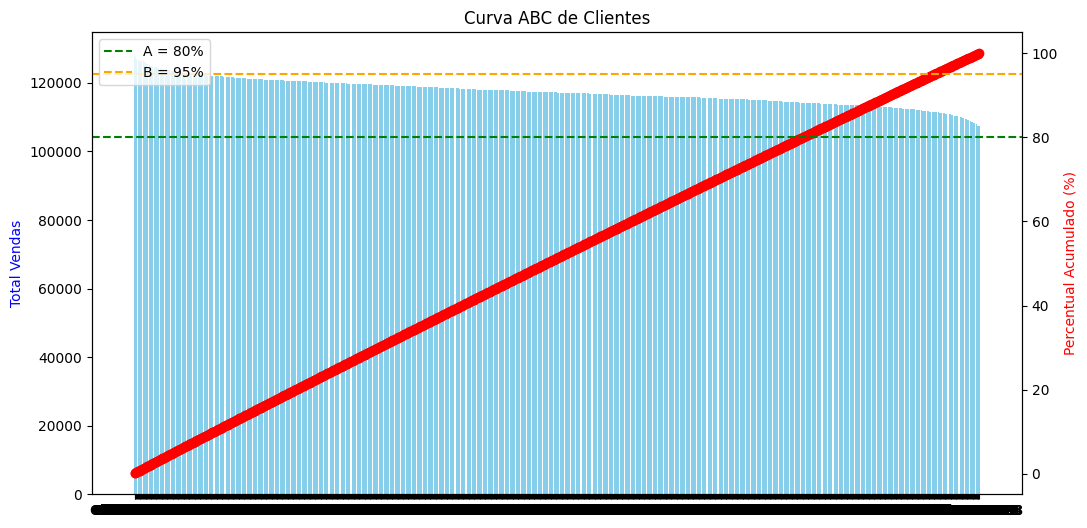

In [0]:

# Grafico de Pareto
fig, ax1 = plt.subplots(figsize=(12,6))
df = vendas.toPandas()

# Dominio, clientes 
ax1.bar(df['nome_cliente'], df['valor_total'], color='skyblue')

# Imagem
ax1.set_ylabel('Total Vendas', color='blue')

# Linha do percentual acumulado
ax2 = ax1.twinx()
ax2.plot(df['nome_cliente'], df['percent_acumulado'], color='red', marker='o', linewidth=1)
ax2.set_ylabel('Percentual Acumulado (%)', color='red')

#Limites ABC
ax2.axhline(80, color='green', linestyle='--', label='A = 80%')
ax2.axhline(95, color='orange', linestyle='--', label='B = 95%')

# Infos
ax2.legend(loc='upper left')
plt.title('Curva ABC de Clientes')
plt.show()

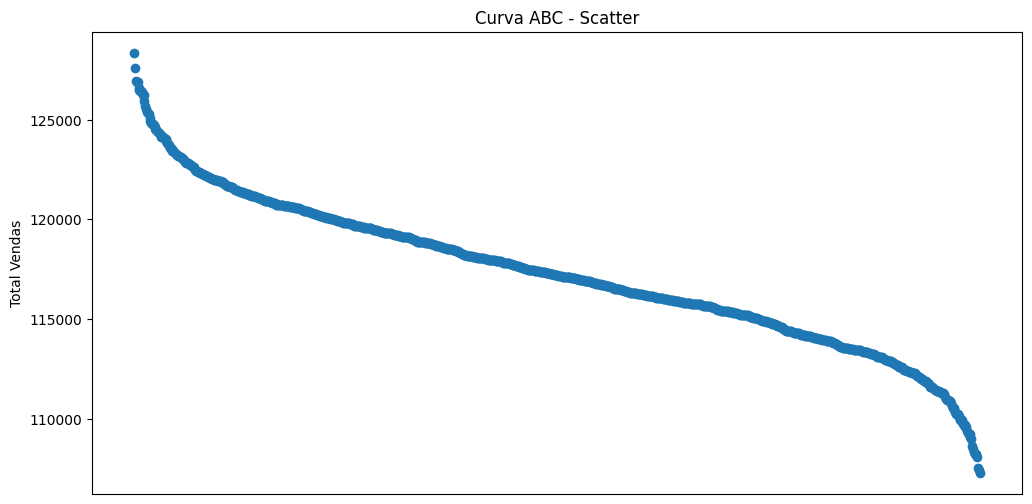

In [0]:

plt.figure(figsize=(12,6))
plt.scatter(df['nome_cliente'], df['valor_total'])
#plt.xlabel('Cliente')
#step = max(1, int(len(df) * 0.1))  # mostra a cada 10% dos dados
#plt.xticks(df['nome_cliente'][::step], df['nome_cliente'][::step], rotation=45)
plt.xticks([])
plt.ylabel('Total Vendas')
plt.title('Curva ABC - Scatter')
plt.show()

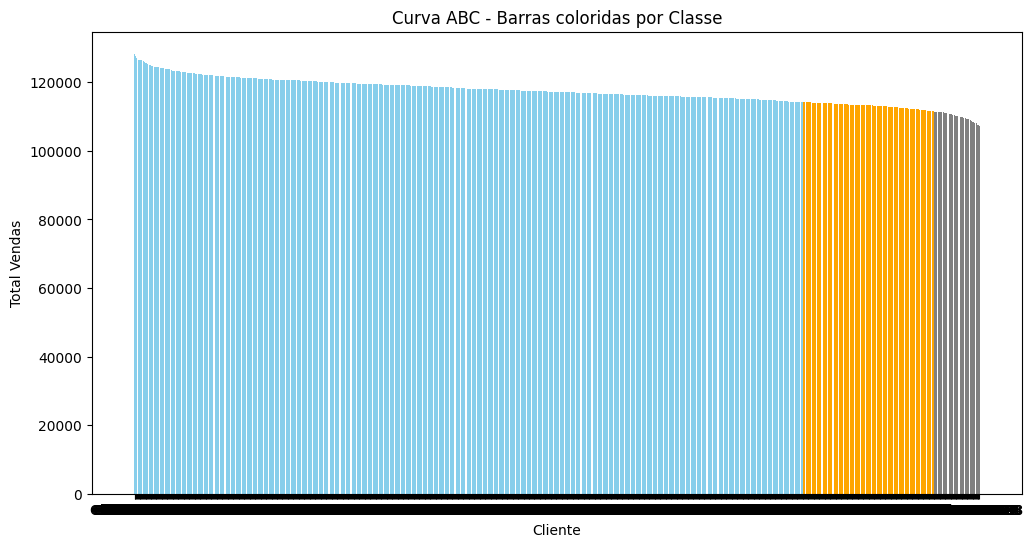

In [0]:

colors = df['abc'].map({'A':'skyblue','B':'orange','C':'gray'})
plt.figure(figsize=(12,6))
plt.bar(df['nome_cliente'], df['valor_total'], color=colors)
plt.xlabel('Cliente')
plt.ylabel('Total Vendas')
plt.title('Curva ABC - Barras coloridas por Classe')
plt.show()

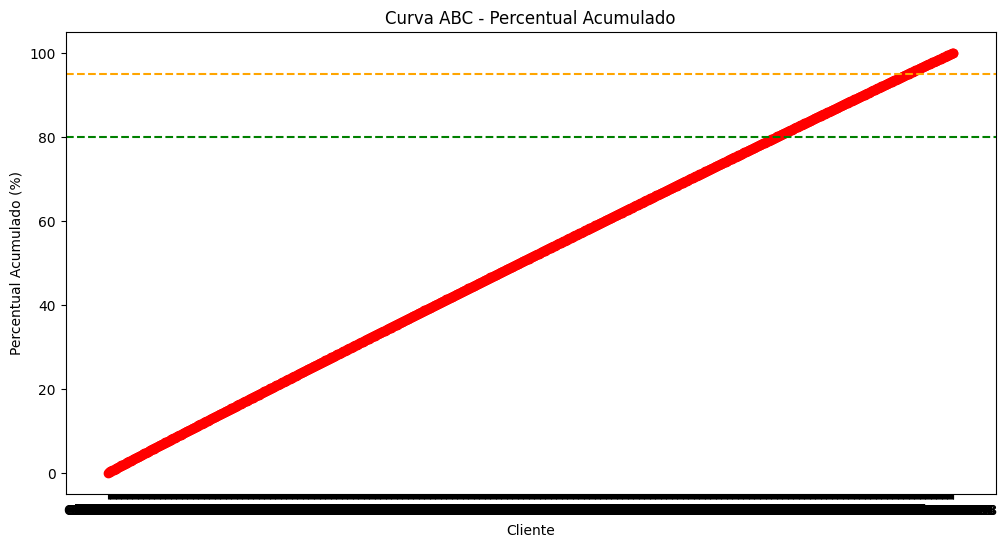

In [0]:

plt.figure(figsize=(12,6))
plt.plot(df['nome_cliente'], df['percent_acumulado'], marker='o', color='red')
plt.axhline(80, color='green', linestyle='--')
plt.axhline(95, color='orange', linestyle='--')
plt.xlabel('Cliente')
plt.ylabel('Percentual Acumulado (%)')
plt.title('Curva ABC - Percentual Acumulado')
plt.show()

**CONCLUSÃO FINAL:** <br>
_A análise da curva ABC de clientes mostra que o faturamento é fortemente concentrado em um grupo relativamente pequeno de clientes, classificados como classe A, que juntos são responsáveis por 80% da receita total. Os gráficos evidenciam uma curva acumulada quase linear no início, com clientes apresentando valores de compra muito próximos entre si, o que indica que não há um único cliente dominante, mas sim um conjunto consistente de clientes estratégicos com alto valor agregado. Esse perfil reforça a importância de ações focadas de retenção, relacionamento e fidelização para os clientes da classe A, pois pequenas perdas nesse grupo podem gerar impactos significativos no faturamento, enquanto clientes das classes B e C representam oportunidades secundárias de crescimento incremental._